In [4]:
import sys
sys.path.append('preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [5]:
def linear(col1,col2):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

def Gauss(x,mu,sig2):
    '''
    Gaussian PDF
    '''
    exparg = -0.5*x**2/sig2
    norm = (2.*np.pi*sig2)**0.5
    return np.exp(exparg)/norm

def Add_noise(T,Tout,PT,Pzero,sig2):
    '''
    Adds a noise PDF to a given PDF convoluting them
    
    params: 
    T: temperature vector
    PT: PDF of temperature
    Pzero: The value of P(T=0) (i.e., P(N=0))
    sig2: variance of the noise PDF
    '''
    conv = np.zeros(len(Tout))*PT.unit
    for i in range(len(Tout)):
        conv[i] = np.trapz(Gauss(Tout[i]-T,0.,sig2)*PT,T)
    conv += Pzero*Gauss(Tout,0.,sig2)
    
    return conv

def get_VID(M):
    #Compute Bnoise
    sig2 = M.sigma_N**2
    Nsigma = 5
    Tmax = max(Nsigma*sig2.value**0.5,M.T[-1].value)
    TTe = np.linspace(-Nsigma*sig2.value**0.5,Tmax,2**15)*M.T.unit
    TT = vut.binedge_to_binctr(TTe)
    dTT = np.diff(TTe)

    PTN = Gauss(TT,0.,sig2).to((TT**-1).unit)

    #Tmin_i,Tmax_i,nT_i = -25*u.K,200*u.K,50
    #Tbin = ut.ulinspace(Tmin_i,Tmax_i,nT_i+1)
    Tbin=np.concatenate((-np.logspace(np.log10(25), -1 ,20), np.logspace(-1, np.log10(200),130)))*u.K

    Ti = vut.binedge_to_binctr(Tbin)

    Balpha_noise_overNvox = vut.pdf_to_histogram(TT,PTN,Tbin,1,0.*Ti.unit,0.)

    #Get PT
    TT2=np.concatenate((np.linspace(-Nsigma*sig2.value**0.5,0,400)*M.T.unit,M.T))
    PT=np.concatenate((np.zeros(400)*M.PT.unit,M.PT))

    #Get Balpha (no noise)
    Balpha_signal_overNvox = vut.pdf_to_histogram(TT2,PT,Tbin,1,0.*Ti.unit,M.PT_zero)
    
    #get PTtot convoluting both
    Toute = np.linspace(-Nsigma*sig2.value**0.5,M.Tedge[-1].value,2**8+1)*M.T.unit
    #TTe = np.logspace(np.log10(M.Tedge[0].value),np.log10(M.Tedge[-1].value),2**15+1)*M.T.unit
    Tout = vut.binedge_to_binctr(Toute)

    PT_total = Add_noise(TT2,Tout,PT,M.PT_zero,sig2)

    Balpha_tot_overNvox = vut.pdf_to_histogram(Tout,PT_total,Tbin,1,0.*Ti.unit,0.)
    Bi=Balpha_tot_overNvox*M.Nvox
    
    return Ti, Bi

## Setting parameters for lim and lightcones

In [6]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    Z=2.9
    DZ=1
    nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
    model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                        sigma_scatter=0.3,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':SFR_file,'sig_SFR':0.6},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=True, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=15.6*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=1000, 
                      beam_FWHM=4*u.arcmin, 
                      tobs=10000*u.hr,
                      Omega_field=400*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys):
    nu_CO=115.271*u.GHz
    z_min = 2.4
    z_max = 3.4
    model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.02*u.Mpc**-1)
    obs_params=dict(zmin = z_min-0.03, zmax = z_max+0.03,
                    RAObs_min=-5*u.deg,RAObs_max=5*u.deg,
                    DECObs_min=-5*u.deg,DECObs_max=5*u.deg,
                    RA_min=-5*u.deg,RA_max=5*u.deg,
                    DEC_min=-5*u.deg,DEC_max=5*u.deg,
                    nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                    beam_FWHM=4*u.arcmin, 
                    dnu=15.6*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=1000, 
                    tobs=10000*u.hr,
                    linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                    do_smooth=True)
    obs_params.update(model_params)
    return obs_params

In [7]:
m_bwc = lim(lim_params('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_Behroozi.dat', 10))
m_um = lim(lim_params('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat', 10))

In [8]:
logM=np.log10(m_bwc.M.value)
sfr_um = SFR_Mz_2dinterp(10**logM, m_bwc.z,'/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat')
sfr_bwc = SFR_Mz_2dinterp(10**logM,m_bwc.z,'/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_Behroozi.dat')          

In [9]:
Ti_bwc, Bi_bwc=get_VID(m_bwc)
Ti_um, Bi_um=get_VID(m_um)

/home-2/gsatopo1@jhu.edu/library/lim/source/line_model.py:741: RuntimeWarning: divide by zero encountered in log
  CLF_of_M[iM,:] = lognormal(self.L,np.log(self.LofM[iM].value)-0.5*sigma_base_e**2.,sigma_base_e)*self.dndM[iM]


Note: redshifts have been re-sorted (earliest first)


/home-2/gsatopo1@jhu.edu/library/lim/source/tools/_vid_tools.py:77: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  h[ii] = quad(PTi,Tedge[ii].value,Tedge[ii+1].value)[0]*Nvox


Note: redshifts have been re-sorted (earliest first)


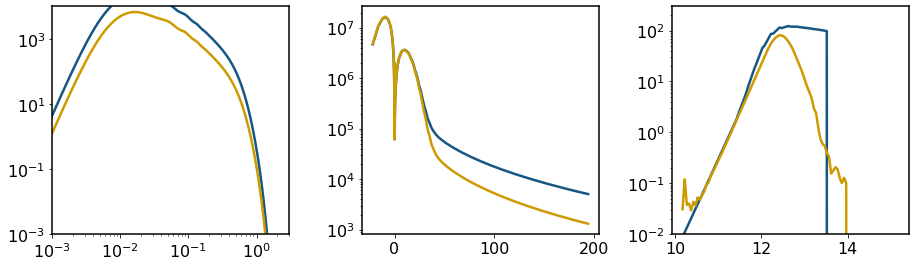

In [10]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.loglog(m_bwc.k, m_bwc.Pk_0)
plt.loglog(m_um.k, m_um.Pk_0)
plt.ylim(1e-3, 1e4)
plt.xlim(1e-3, 3)

plt.subplot(1,3,2)
plt.plot(Ti_bwc, Bi_bwc)
plt.plot(Ti_um, Bi_um)
plt.yscale('log')
#plt.ylim(1e-3, 1e4)
#plt.xlim(1e-3, 3)

plt.subplot(1,3,3)
plt.plot(logM, sfr_bwc)
plt.plot(logM, sfr_um)
plt.yscale('log')
plt.ylim(1e-2, 3e2)
plt.tight_layout()

### DC SFR parametrization

In [11]:
def sfr_dc(m, A, B, C, M_h):
    '''
    Parametrization for SFR(M) based off of 2111.05931 parametrization.
    Equation is: 
    
    SFR(M) = C / ((M/M_h)**A + (M/M_h)**B)
    
    so
    A = low-M slope
    B = high-M slope
    C = amplitude at tilt scale
    M_h = tilt mass
    
    
    Note original use is for L_CO (M_h) but here we'll 
    choose SFR(M_h) instead. Should be equivalent but double check.
    '''
    ratio = m/10**M_h
    
    return np.log10(C/(ratio**A + ratio**B))

In [12]:
popt_um, pcov = curve_fit(sfr_dc, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[3,-1.4,10,12.5])
popt_bwc, pcov = curve_fit(sfr_dc, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[3,-1.4,10,12.5])

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


(-2.0, 3.0)

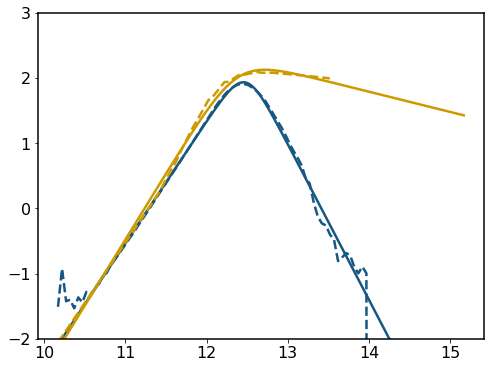

In [13]:
A_um, B_um, C_um, Mh_um = popt_um
plt.plot(logM,sfr_dc(10**logM, A_um, B_um, C_um, Mh_um), 'C0')
plt.plot(logM, np.log10(sfr_um), 'C0--')

A_bwc, B_bwc, C_bwc, Mh_bwc = popt_bwc
plt.plot(logM, sfr_dc(10**logM, A_bwc, B_bwc, C_bwc, Mh_bwc), 'C1')
plt.plot(logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3], '--C1')

plt.ylim(-2, 3)

## Lightcone

Load the lightcone for the full area ($\Omega_{field} = 100$ deg$^2$) and compute the VID for both BWC and UM

In [15]:
model_bwc=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=10**Mh_bwc)
LC = make_measurements(LC_params(True, 'Dongwoo_SFR', model_bwc, 10))
bwc_map=LC.obs_3d_map

model_um=dict(A=A_um, B=B_um, C=C_um, M_h=10**Mh_um)
LC.update(SFR_pars=model_um)
um_map=LC.obs_3d_map

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

In [39]:
bwc_map=np.asarray(bwc_map)
um_map=np.asarray(um_map)

In [27]:
Ti_edge=np.concatenate((-np.logspace(np.log10(25), -1 ,20), np.logspace(-1, np.log10(200),130)))
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

Bi_LCbwc=np.histogram(bwc_map.value.flatten(), bins=Ti_edge)[0]
Bi_LCum=np.histogram(um_map.value.flatten(), bins=Ti_edge)[0]

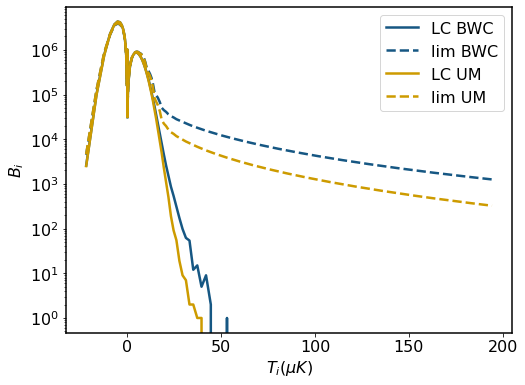

In [50]:
plt.plot(Ti, Bi_LCbwc, 'C0', label='LC BWC')
plt.plot(Ti_bwc, Bi_bwc, 'C0--', label='lim BWC')
plt.plot(Ti, Bi_LCum, 'C1', label='LC UM')
plt.plot(Ti_um, Bi_um, 'C1--', label='lim UM')
plt.xlabel('$T_i(\mu K)$')
plt.ylabel('$B_i$')
plt.yscale('log')
plt.legend()

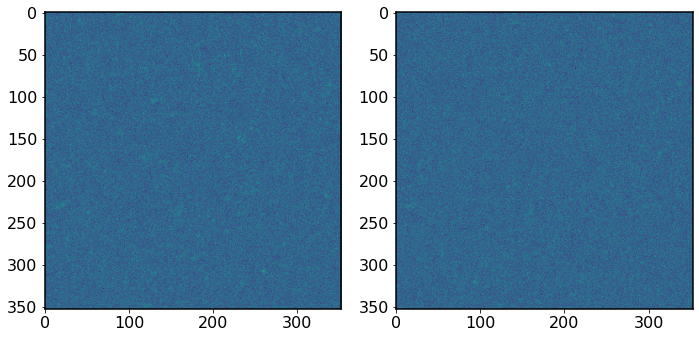

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(bwc_map[0,:,:], vmin=np.min([bwc_map,um_map]), vmax=np.max([bwc_map,um_map]))
#plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(um_map[0,:,:], vmin=np.min([bwc_map,um_map]), vmax=np.max([bwc_map,um_map]))
#plt.colorbar()
plt.tight_layout()

### Dividing into subfields

In [16]:
cut_edges=np.arange(-10, 10.1, 10/3)
maps_cut=[]
maps_plus=[]
maps_minus=[]
deriv_cut=[]        
for i in range(len(cut_edges)-1):
    for j in range(len(cut_edges)-1):
        LC.update(RAObs_min=cut_edges[i]*u.deg,RAObs_max=cut_edges[i+1]*u.deg,
                  DECObs_min=cut_edges[j]*u.deg,DECObs_max=cut_edges[j+1]*u.deg,
                  RA_min=cut_edges[i]*u.deg,RA_max=cut_edges[i+1]*u.deg,
                  DEC_min=cut_edges[j]*u.deg,DEC_max=cut_edges[j+1]*u.deg,
                  SFR_pars=model_bwc)
        maps_cut.append(np.asarray(LC.obs_3d_map))
        
        LC.update(SFR_pars=dict(A=A_bwc*(1.05), B=B_bwc, C=C_bwc, M_h=10**Mh_bwc))
        maps_plus.append(np.asarray(LC.obs_3d_map))
        print(LC.RAObs_min, LC.RAObs_max, LC.DECObs_min, LC.DECObs_max, LC.SFR_pars)
        
        LC.update(SFR_pars=dict(A=A_bwc*(0.95), B=B_bwc, C=C_bwc, M_h=10**Mh_bwc))
        maps_minus.append(np.asarray(LC.obs_3d_map))
        print(LC.SFR_pars)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_174.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_175.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_176.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_177.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_174.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_175.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_176.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_177.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_178.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_179.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_180.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_181.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_182.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_183.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_184.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_185.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_181.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_182.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_183.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_184.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_185.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_186.fits
-6.666666666666666 deg -3.333333333333332 deg 1.7763568394002505e-15 deg 3.3333333333333357 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.

{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_174.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_174.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_175.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_176.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_177.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_178.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_179.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_180.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_181.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_177.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_178.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_179.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_180.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_181.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_182.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_183.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_184.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_185.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_186.fits
1.7763568394002505e-15 deg 3.3333333333333357 deg 3.3333333333333357 deg 6.666666666666671 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_184.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_185.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_186.fits
3.3333333333333357 deg 6.666666666666671 deg -6.666666666666666 deg -3.333333333333332 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits


/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_174.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_175.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_176.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_177.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_174.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_175.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_176.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_177.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_178.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_179.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_180.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_181.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_182.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_183.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_184.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

In [17]:
#Ti_edge=np.concatenate((-np.logspace(np.log10(100), -1 ,20), np.logspace(-1, np.log10(100),20)))
Ti_edge=np.linspace(-20, 50, 30)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
Bi_cut=[]
deriv_cut=[]
for i in range(len(maps_cut)):
    Bi_cut.append(np.histogram((maps_cut[i]).flatten(), bins=Ti_edge)[0])
    Bi_plus=np.histogram(maps_plus[i].flatten(), bins=Ti_edge)[0]
    Bi_minus=np.histogram(maps_minus[i].flatten(), bins=Ti_edge)[0]
    deriv_cut.append((Bi_plus-Bi_minus)/(A_bwc*0.1))

In [18]:
Nvox=LC.Nchan*LC.Npix
varBi_cut=np.asarray([Bi_cut[i]*(1-Bi_cut[i]/Nvox) for i in range(len(Bi_cut))])

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main

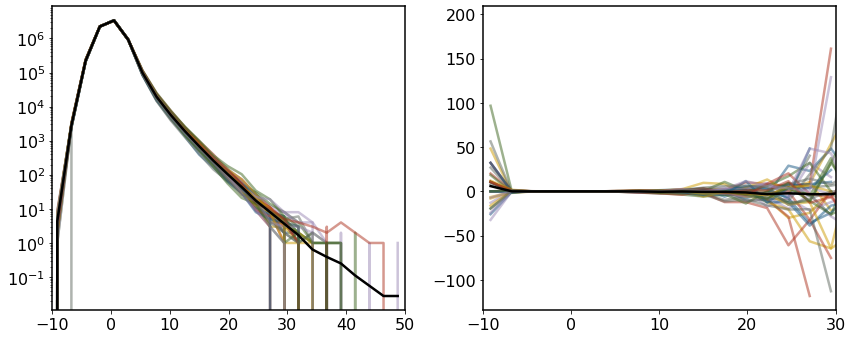

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for i in range(len(Bi_cut)):
    plt.plot(Ti, Bi_cut[i], alpha=0.5)
plt.plot(Ti, np.average(Bi_cut, axis=0), 'k')
plt.yscale('log')
plt.xlim(-10, 50)

plt.subplot(1,2,2)
for i in range(len(deriv_cut)):
    plt.plot(Ti, deriv_cut[i]/Bi_cut[i], alpha=0.5)
plt.plot(Ti, np.average(deriv_cut, axis=0)/np.average(Bi_cut, axis=0), 'k')
plt.xlim(-10, 30)
plt.tight_layout()

In [20]:
Nbins=[9, 24, 39, 54, 69]
Bi_bins=[]
deriv_bins=[]
for n in Nbins:
    Ti_edge=np.linspace(-20, 50, n)
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    
    Bi_cut=[]
    deriv_cut=[]
    for i in range(len(maps_cut)):
        Bi_cut.append(np.histogram((maps_cut[i]).flatten(), bins=Ti_edge)[0])
        Bi_plus=np.histogram(maps_plus[i].flatten(), bins=Ti_edge)[0]
        Bi_minus=np.histogram(maps_minus[i].flatten(), bins=Ti_edge)[0]
        deriv_cut.append((Bi_plus-Bi_minus)/(A_bwc*0.1))
    Bi_bins.append(np.average(Bi_cut, axis=0))
    deriv_bins.append(np.average(deriv_cut, axis=0))

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted 

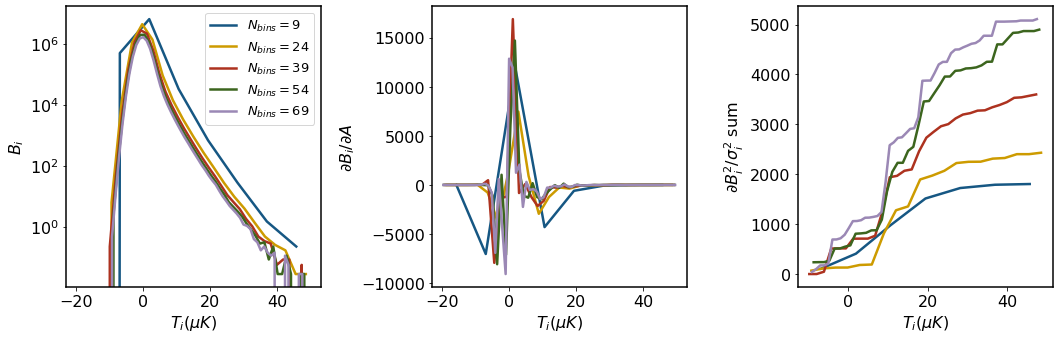

In [43]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for n in range(len(Nbins)):
    Ti_edge=np.linspace(-20, 50, Nbins[n])
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    plt.plot(Ti, Bi_bins[n], label='$N_{bins}=$'+str(Nbins[n]))
plt.yscale('log')
plt.xlabel('$T_i (\mu K)$')
plt.ylabel('$B_i$')
plt.legend(fontsize=13)

plt.subplot(1,3,2)
for n in range(len(Nbins)):
    Ti_edge=np.linspace(-20, 50, Nbins[n])
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

    plt.plot(Ti, deriv_bins[n])
#plt.yscale('log')
plt.xlabel('$T_i (\mu K)$')
plt.ylabel('$\partial B_i/\partial A$')

plt.subplot(1,3,3)
for n in range(len(Nbins)):
    Ti_edge=np.linspace(-20, 50, Nbins[n])
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    
    mask=[(Bi_bins[n])>0]
    varBi=np.asarray((Bi_bins[n])[mask]*(1-(Bi_bins[n])[mask]/Nvox))
    plt.plot(Ti[mask], np.cumsum((deriv_bins[n])[mask]**2/varBi))
plt.xlabel('$T_i (\mu K)$')
plt.ylabel('$\partial B_i^2/\sigma_i^2$ sum')
plt.tight_layout()
plt.savefig('VID_varyA.png', dpi=300)

In [ ]:
model_bwc=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=10**Mh_bwc)
steps_bwc=dict(A=0.05*model_bwc['A'], B=0.05*model_bwc['B'], C=0.05*model_bwc['C'], M_h=10**(0.05*np.log10(model_bwc['M_h'])))
tmp_pars=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=10**Mh_bwc)

Ti_edge=np.linspace(-20, 50, 30)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
derivs_bwc=np.zeros((len(model_bwc), 9, len(Ti)))
P0_bwc=np.zeros((len(fid_bwc), m.nk))
i=0
for par in fid_bwc.keys():
    tmp_pars.update({par:fid_bwc[par]+steps_bwc[par]})
    m.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=tmp_pars))
    print('plus',tmp_pars)
    P0_plus=0.5*np.trapz(m.Pk+m.Pnoise, m.mu, axis=0)
    
    tmp_pars.update({par:fid_bwc[par]-steps_bwc[par]})
    m.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=tmp_pars))
    print('minus',tmp_pars)
    P0_minus=0.5*np.trapz(m.Pk+m.Pnoise, m.mu, axis=0)
    
    tmp_pars.update({par:fid_bwc[par]})
    m.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=tmp_pars))
    print('fiducial',tmp_pars)
    
    derivs_bwc[i]=(P0_plus-P0_minus)/(2.*steps_bwc[par])
    P0_bwc[i]=0.5*np.trapz(m.Pk+m.Pnoise, m.mu, axis=0)
    i+=1